First we load the data, the models, and their return predictions.

We add a day to the df index because:
1. when we stored the test_predictions, we used the last N days of available data.
2. this means that we predict the last N-1 days and the day after.

# TODO

## ADD TUSDT, XRPUSDT instead of UNIUSDT (better coinindex)

## Show a colormap plotting of meanvariance weights and window sizes (and how they perform compared to the markowitz model)

## Uniform buy and hold

## Currently running with sentiment score. Try without

In [104]:
tickers = ["BTCUSDT", "DOGEUSDT", "ETHUSDT", "SOLUSDT", "UNIUSDT"]

import pandas as pd
import joblib
%store -r test_predictions
pred_close = pd.DataFrame(test_predictions)
pred_close.index = pred_close.index + pd.Timedelta(days=1)

for ticker in tickers:
    scaler = joblib.load(f"scalers/{ticker}_scaler.pkl")
    seventeen_columns = pd.concat([pred_close[ticker]] * 17, axis=1)

    pred_close[ticker] = scaler.inverse_transform(seventeen_columns)[:, 0]

In [106]:
pred_close

,SOLUSDT,BTCUSDT,ETHUSDT,DOGEUSDT,UNIUSDT
Open time,,,,,
2023-08-15,25.481514,31984.294922,1864.156982,0.073371,5.666057
2023-08-16,26.764664,31995.353516,1860.309326,0.072160,5.759100
2023-08-17,25.622612,31876.861328,1842.507202,0.071538,5.631508
2023-08-18,24.001013,31581.052734,1813.569092,0.070998,5.326704
2023-08-19,23.226498,31893.685547,1766.099487,0.070575,5.013563
...,...,...,...,...,...
2023-12-28,107.495872,42257.128906,2216.883301,0.089956,7.017346
2023-12-29,105.965340,42343.355469,2313.547363,0.090527,6.948269
2023-12-30,103.665703,42476.464844,2323.027832,0.089721,7.359361


In [ ]:
import data
import pandas as pd

dfs = [data.load_asset(ticker, sampling="1d") for ticker in tickers]
dfs = [data.subset(df, start=pd.Timestamp('2021-01-01'), end=pd.Timestamp('2023-12-31')) for df in dfs]
dfs = [data.add_returns(df) for df in dfs]
dfs = [df.dropna() for df in dfs]

opens = pd.concat([df["Open"] for df in dfs], axis=1, keys=tickers)

true_returns = pd.concat(
    [df["Return"].reindex(preds.index) for df, preds in zip(dfs, test_predictions.values())], 
    axis=1,
    keys=tickers
)

Now we calculate the Markowitz weights

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:89: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


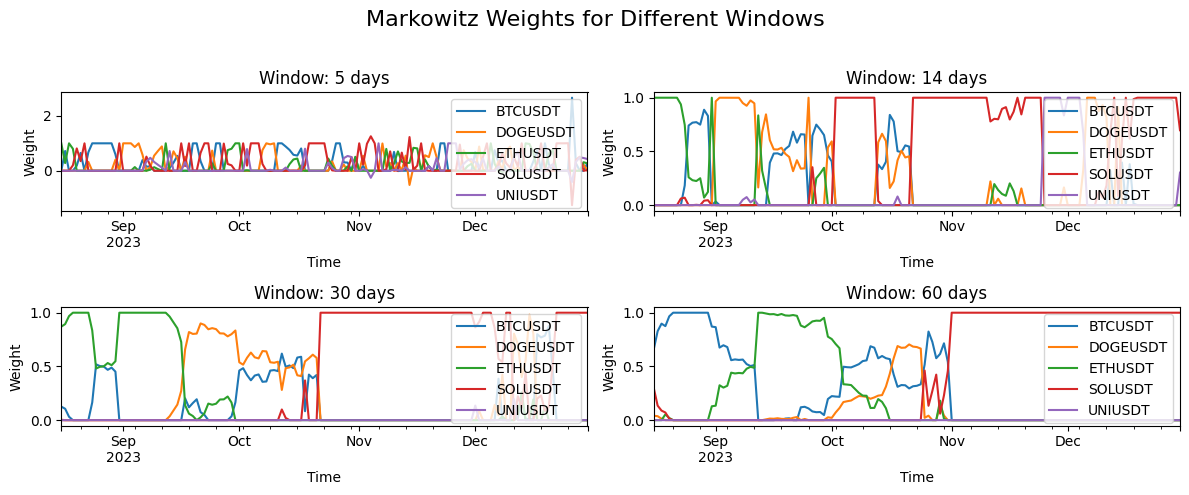

In [163]:
import matplotlib.pyplot as plt, numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns

MarkMVO = []
MarkMVO_windows = PredMVO1_windows # windows = [30, 180, 480, 9999]
for window in windows:
    portfolio_returns = []
    portfolio_weights = []
    start_date = pd.Timestamp('2023-08-14')

    # Iterate through each day after March 1, 2024
    for current_date in dfs[-1].index[dfs[-1].index > start_date]:
        # Filter data up to the current date
        data_up_to_today = opens.loc[:current_date]
        if len(data_up_to_today) > window:
            data_up_to_today = data_up_to_today[-window:]

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
        cov_matrix = risk_models.sample_cov(data_up_to_today)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        weights = ef.max_sharpe(risk_free_rate=-10)
        cleaned_weights = ef.clean_weights()

        # Get returns for the current day (next day's returns based on today's weights)
        daily_returns = pd.DataFrame(
            {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
            index=[current_date]
        ).loc[current_date]

        weights["day"] = current_date + pd.Timedelta(days=1)

        # Calculate portfolio return using today's weights
        portfolio_weights.append(weights)
        # portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
        # portfolio_returns.append(portfolio_return)

    # Convert portfolio returns into a DataFrame with appropriate index
    # portfolio_returns_df = pd.DataFrame(portfolio_returns, index=pd.date_range(start=start_date, periods=len(portfolio_returns), freq='D'), columns=['Portfolio Return'])

    # Plot the portfolio returns
    # (1 + portfolio_returns_df).cumprod().plot(figsize=(10, 6), title="Cumulative Portfolio Returns")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    # plt.show()
    plt.close()

    portfolio_weights = pd.DataFrame(portfolio_weights)
    portfolio_weights.index = portfolio_weights["day"]
    portfolio_weights.drop(columns=["day"], inplace=True)
    MarkMVO.append(portfolio_weights)

fig, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.suptitle("Markowitz Weights for Different Windows", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(MarkMVO):
        MarkMVO[i].plot(ax=ax, title=f"Window: {windows[i]} days")
        ax.set_xlabel("Time")
        ax.set_ylabel("Weight")
        ax.legend(loc="upper right")
    else:
        ax.axis("off")  # Turn off unused subplots

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

There are a number of ways that we can incorporate prediction in the optimization program.

1. Use the predictions to augment the "historical" price data

    Note that for larger windows, we will have to augment this (so it's weighted more in the mean and covariance calculations)
2. Use the predictions to shift the locally expected mean returns (but use very long historical correlation)
3. Dynamically rebalance the portfolio weights


NOTE: what does the "current_date" in the for loop mean?
1. At the end of the day "current_date", we decide the portfolio weights
2. Before and including "current_date," we have all our historical data
3. The price prediction is for the day after "current_date"

The index of portfolio_weights is the day on which the weights are being used.

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:89: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


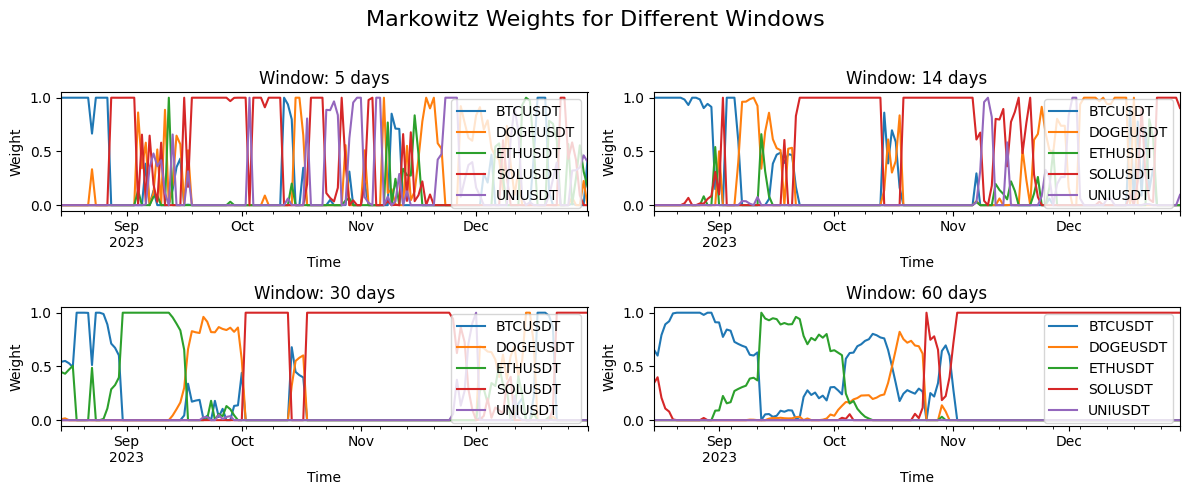

In [ ]:

PredMVO1_windows = windows = [5, 14, 30, 60]
PredMVO1 = []

# lmbda = 0.5

for window in windows:
    portfolio_weights = []
    for current_date in dfs[-1].index[dfs[-1].index >= start_date]:
        # Filter data up to the current date
        data_up_to_today = opens.loc[:current_date]
        if len(data_up_to_today) > window:
            data_up_to_today = data_up_to_today[-window:]


        next_day = current_date + pd.Timedelta(days=1)
        new_row = pd.DataFrame([pred_close.loc[next_day]], index=[next_day])
        extra_data_up_to_today = pd.concat([data_up_to_today, new_row])

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(extra_data_up_to_today, frequency=365)
        cov_matrix = risk_models.sample_cov(data_up_to_today)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        weights = ef.max_sharpe(risk_free_rate=-10)
        cleaned_weights = ef.clean_weights()

        # Get returns for the current day (next day's returns based on today's weights)
        daily_returns = pd.DataFrame(
            {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
            index=[current_date]
        ).loc[current_date]

        # Calculate portfolio return using today's weights

        # Normalize portfolio weights to ensure they sum to 1
        weights_sum = sum(i for i in weights.values() if i >= 0)
        if weights_sum > 10:
            print(weights)
        if weights_sum != 0:
            weights = {key: max(0, value / weights_sum) for key, value in weights.items()}
        weights["day"] = next_day
        
        portfolio_weights.append(weights)
        # portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
        # portfolio_returns.append(portfolio_return)
    portfolio_weights = pd.DataFrame(portfolio_weights)
    portfolio_weights.index = portfolio_weights["day"]
    portfolio_weights.drop(columns=["day"], inplace=True)
    PredMVO1.append(portfolio_weights)


fig, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.suptitle("Markowitz Weights for Different Windows", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(PredMVO1):
        PredMVO1[i].plot(ax=ax, title=f"Window: {windows[i]} days")
        ax.set_xlabel("Time")
        ax.set_ylabel("Weight")
        ax.legend(loc="upper right")
    else:
        ax.axis("off")  # Turn off unused subplots

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

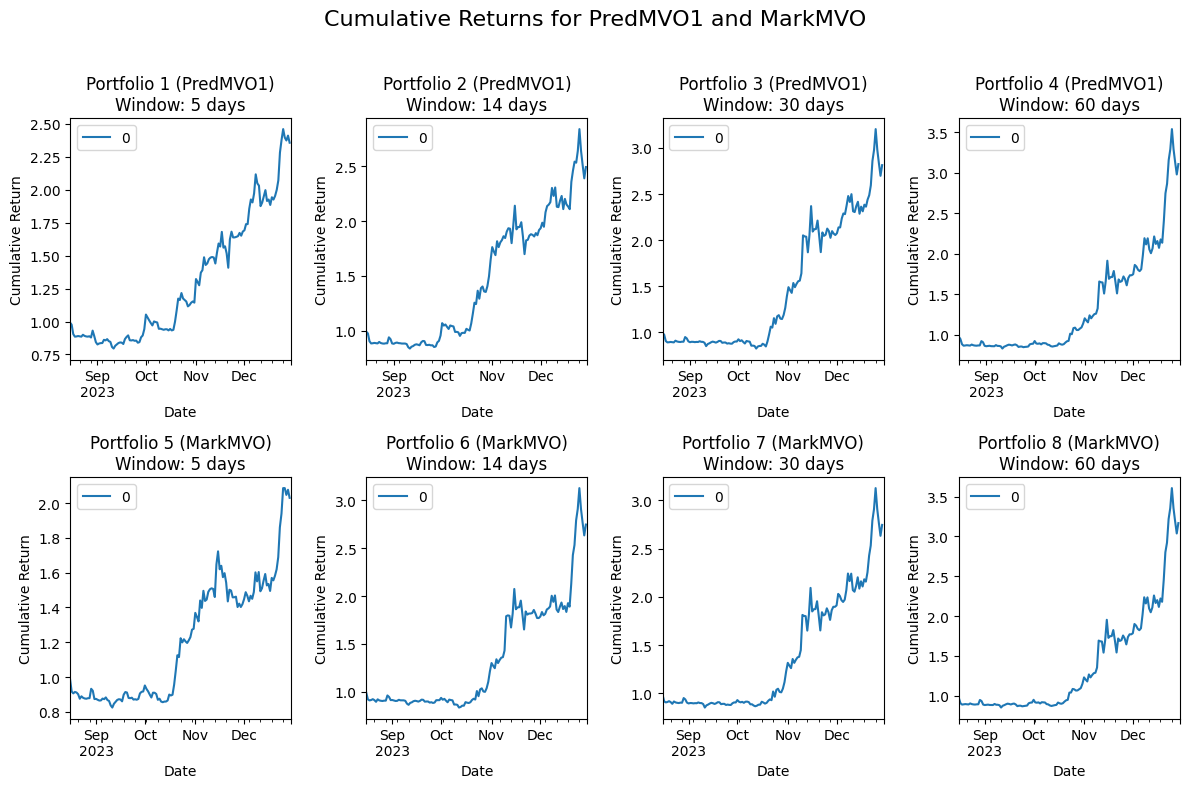

In [164]:
def calculate_cumulative_returns(df):
    portfolio_returns = np.array([
        np.dot(true_returns.loc[date], df.loc[date]) for date in df.index
    ])
    cumulative_returns = (1 + portfolio_returns).cumprod()
    return pd.DataFrame(cumulative_returns, index=df.index)

# Plot cumulative returns for each DataFrame in PredMVO1 and MarkMVO
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.suptitle("Cumulative Returns for PredMVO1 and MarkMVO", fontsize=16)

for i, (df, ax) in enumerate(zip(PredMVO1 + MarkMVO, axes.flatten())):
    cumulative_returns = calculate_cumulative_returns(df)
    cumulative_returns.plot(ax=ax, title=f"Portfolio {i + 1} ({'PredMVO1' if i < len(PredMVO1) else 'MarkMVO'})\nWindow: {PredMVO1_windows[i] if i < len(PredMVO1) else MarkMVO_windows[i - len(PredMVO1)]} days")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return")
    ax.legend(loc="upper left")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
